In [185]:
# !pip install pandas_datareader

In [186]:
import math
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas_datareader as pdr
from datetime import datetime, timedelta

In [187]:
#Get the stock
ticker = 'TSLA'
stock ="Tesla"
# Time step n days, here we will use n  days historical data to predict next day closing
ts_points = 120
# train_data[0:60,0]  

today = datetime.today()
# start_date ='2016-01-01'
start_date = (today - timedelta(days=5*365) ).strftime('%Y-%m-%d')

end_date   = today.strftime('%Y-%m-%d')
stock_df = pdr.DataReader(ticker, data_source="yahoo", start=start_date, end=end_date)

In [188]:
# Date is an index but to be sure , let's sort
stock_df = stock_df.sort_index(ascending=True)
stock_df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-10-24,40.790001,40.049999,40.200001,40.551998,13758000.0,40.551998
2016-10-25,40.938000,40.240002,40.580002,40.467999,12225000.0,40.467999
2016-10-26,40.638000,40.020000,40.200001,40.448002,28164000.0,40.448002
2016-10-27,42.740002,40.330002,42.268002,40.801998,65468500.0,40.801998
2016-10-28,41.063999,39.966000,40.799999,39.993999,21400500.0,39.993999
...,...,...,...,...,...,...
2021-10-18,875.260010,851.469971,851.789978,870.109985,24207200.0,870.109985
2021-10-19,877.950012,862.510010,877.530029,864.270020,17381100.0,864.270020
2021-10-20,869.489990,857.380005,865.349976,865.799988,14032100.0,865.799988


In [189]:
# check for nulls
stock_df.isna().sum()

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [190]:
# Get shape
stock_df.shape

(1259, 6)

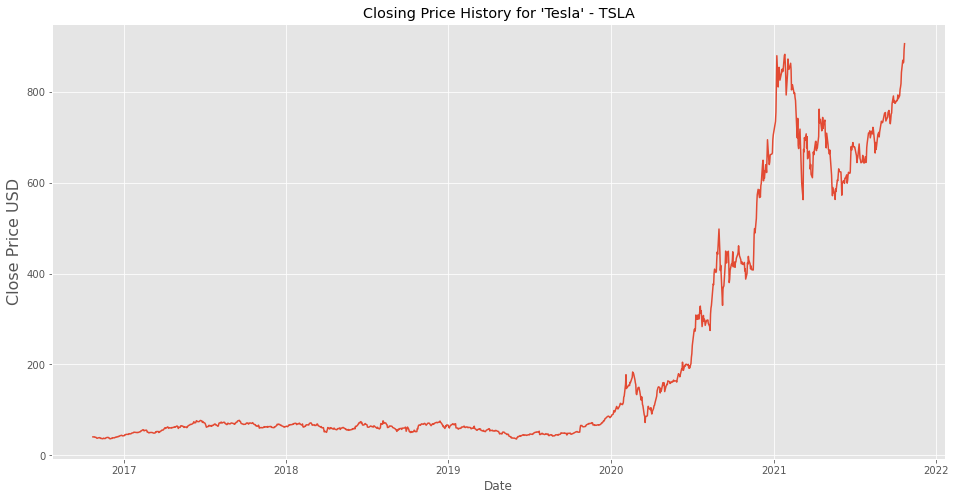

In [191]:
# Visualize closing price history
plt.figure(figsize=(16,8))
plt.title (f"Closing Price History for '{stock}' - {ticker}")
plt.plot(stock_df['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price USD', fontsize=16)
plt.show()

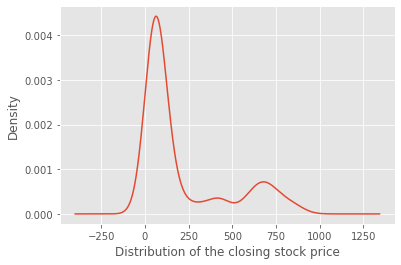

In [192]:
stock_df['Close'].plot.density()
plt.xlabel('Distribution of the closing stock price')
plt.show()

In [193]:
# DF with only close
TSdata_df = stock_df.filter(['Close'])
TSdata_arr = TSdata_df.values # this creates an array of Close Price
TSdata_arr

array([[ 40.55199814],
       [ 40.4679985 ],
       [ 40.44800186],
       ...,
       [865.79998779],
       [894.        ],
       [906.51000977]])

In [194]:
# Scale the Data
scaler = MinMaxScaler(feature_range =(0,1))
scaled_data = scaler.fit_transform(TSdata_arr)
# scaled_data

In [195]:
training_data_len = math.ceil(len(TSdata_arr) * 0.75)
training_data_len

945

In [196]:
# Created scaled training dataset
train_data = scaled_data[0:training_data_len]
train_data.shape

(945, 1)

In [197]:
# Split
X_train = []
y_train = []

for i in range(ts_points, len(train_data)):
    X_train.append(train_data[i-ts_points:i,0])
    y_train.append(train_data[i,0])
    # if i <= ts_points+3:
    #     print(X_train)
    #     print(y_train)
    #     print()


In [198]:
# convert X_train and y_train to numpy arrays for LSTM
X_train, y_train = np.array(X_train), np.array(y_train)

In [199]:
print (X_train.shape)
print (y_train.shape)

(825, 120)
(825,)


In [200]:
# LSTM network expects a 3D input (No_of_Samples, number of time steps, and number of features) no_of_features = 1 (Close)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(825, 120, 1)

In [201]:
training_data_len - ts_points

825

In [202]:
# hidden_nodes = int(2/3 * (X_train.shape[1] * 1))
# print(f"The number of hidden nodes is {hidden_nodes}.")

In [203]:
# LSTM MOdel
model = tf.keras.models.Sequential()
# model.add(tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],1)))
# model.add(tf.keras.layers.LSTM(50, return_sequences=False))
# model.add(tf.keras.layers.Dropout(0.2))
# model.add(tf.keras.layers.Dense(25))
# model.add(tf.keras.layers.Dense(1))
# model.summary()


In [204]:

# BEST FOR TESLA#
model.add(tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(tf.keras.layers.LSTM(50, return_sequences=False))
# model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(25))
model.add(tf.keras.layers.Dense(1))
model.summary()

#model.fit(X_train, y_train, batch_size=64, epochs=50

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 120, 50)           10400     
_________________________________________________________________
lstm_9 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_8 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [205]:
model.compile(optimizer='adam', loss='mean_squared_error')
# model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [206]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint

batch_size=64

os.makedirs("chk_points/", exist_ok=True)
chkpoint_path="chk_points/weights.{epoch}.hdf5"

# Create chk points
chkpt_callback = ModelCheckpoint(filepath=chkpoint_path,
                              verbose=1,
                              save_weights_only=True,
                              save_freq="epoch",
                              period=5)

# chkpoint_path = "chk_points/cp-{epoch:04d}.ckpt"
# chkpt_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=chkpoint_path, 
#     verbose=1, 
#     save_weights_only=True,
#     save_freq=5*batch_size)                    

# model.save_weights(chkpoint_path.format(epoch=0))    


In [207]:
# training_data_len
# scaled_data

In [208]:
# model.fit(X_train, y_train, batch_size=batch_size, epochs=50, validation_split=0.43, callbacks=[chkpt_callback])
model.fit(X_train, y_train, batch_size=64, epochs=50)

Epoch 1/50
13/13 [==============================] - 3s 76ms/step - loss: 0.0014
Epoch 2/50
13/13 [==============================] - 1s 82ms/step - loss: 2.8500e-04
Epoch 3/50
13/13 [==============================] - 2s 135ms/step - loss: 1.9272e-04
Epoch 4/50
13/13 [==============================] - 2s 142ms/step - loss: 1.3899e-04
Epoch 5/50
13/13 [==============================] - 2s 155ms/step - loss: 1.2918e-04
Epoch 6/50
13/13 [==============================] - 2s 144ms/step - loss: 1.1957e-04
Epoch 7/50
13/13 [==============================] - 2s 168ms/step - loss: 1.2016e-04
Epoch 8/50
13/13 [==============================] - 2s 164ms/step - loss: 1.1475e-04
Epoch 9/50
13/13 [==============================] - 2s 147ms/step - loss: 1.1391e-04
Epoch 10/50
13/13 [==============================] - 2s 136ms/step - loss: 1.2403e-04
Epoch 11/50
13/13 [==============================] - 2s 141ms/step - loss: 1.0675e-04
Epoch 12/50
13/13 [==============================] - 2s 153ms/step - 

In [209]:
model.save('Saved_Models/Model_'+ticker+'.h5')

In [210]:
# test_data = scaled_data[training_data_len:]

# Bring in the last 'ts_points' (60 values) from training set so when X_test is used to predict , predictions have same shape as Y_test
# The for loop starts with 'ts_points' thatbmeans the resultant array will have 60 less rows
test_data = scaled_data[training_data_len-ts_points:]
# test_data[0:60,0]


In [211]:
X_test = []
y_test = TSdata_arr[training_data_len:]
for i in range(ts_points, len(test_data)):
    X_test.append(test_data[i-ts_points:i,0])


In [212]:
# convert the data to a numpy array to use it in LSTM MODEL
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],  X_test.shape[1], 1))

In [213]:
from sklearn.metrics import mean_squared_error

In [214]:
# Models predicted price for X_train
predictions_tr = model.predict(X_train)
predictions_tr = scaler.inverse_transform(predictions_tr)

y_train_tr =  scaler.inverse_transform(y_train.reshape(-1,1))
rmse_tr = math.sqrt(mean_squared_error(y_train_tr, predictions_tr))
rmse_tr

6.4855016709040685

In [215]:
# Models predicted price for X_test
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

In [216]:
y_test.shape, predictions.shape

((314, 1), (314, 1))

In [217]:
# RMSE to check accuracy

rmse = math.sqrt(mean_squared_error(y_test, predictions))
rmse

28.47238888096227

In [218]:
# Plot
train = TSdata_df[:training_data_len]
actual = TSdata_df[training_data_len:]
actual['Predictions'] = predictions
actual

<ipython-input-218-bb86776ae978>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual['Predictions'] = predictions


,Close,Predictions
Date,,
2020-07-28,295.298004,303.503326
2020-07-29,299.821991,299.777496
2020-07-30,297.497986,298.358185
2020-07-31,286.152008,297.859436
2020-08-03,297.000000,295.146484
...,...,...
2021-10-18,870.109985,816.929443
2021-10-19,864.270020,837.229004
2021-10-20,865.799988,852.606506


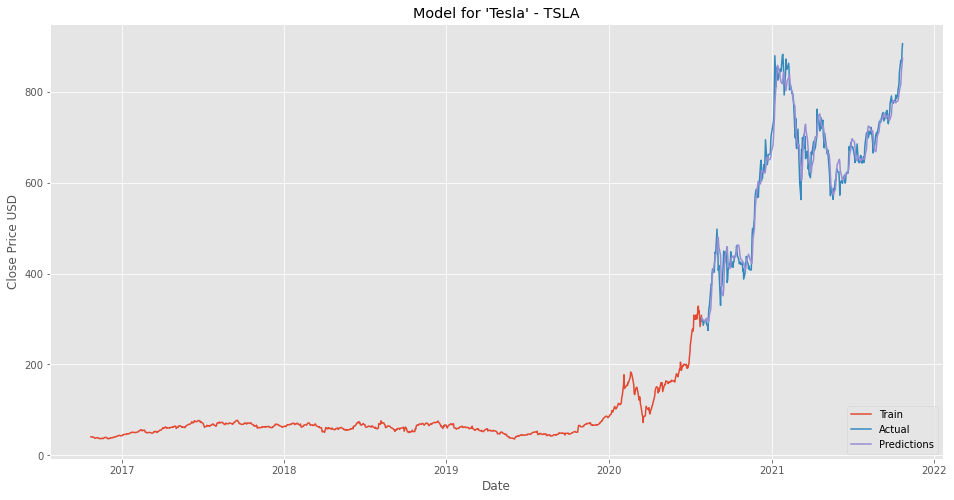

In [219]:
plt.figure(figsize=(16,8))
plt.title(f"Model for '{stock}' - {ticker}")
plt.xlabel("Date")
plt.ylabel("Close Price USD")
plt.plot(train['Close'])
plt.plot(actual[['Close', 'Predictions']])
plt.legend(['Train', 'Actual', 'Predictions'], loc='lower right')
plt.show()

# TEST

In [220]:
# for predictions add 100 extra days to make sure it has more than ts_points to make up for missing days (weekends and holidays)

fetch_days = ts_points + 100    

sd =  today - timedelta(days=fetch_days)
sd = sd.strftime('%Y-%m-%d')

ed = today.strftime('%Y-%m-%d')
ed

next_day = (today + timedelta(days=1) ).strftime('%Y-%m-%d')
# next_day

In [221]:
# get the quote
quote = pdr.DataReader(ticker, data_source="yahoo", start=sd, end=ed)
new_df = quote.filter(['Close'])
last_n_days = ts_points
last_n_days_arr = new_df[-last_n_days:].values 

In [222]:
last_n_days_scaled = scaler.transform(last_n_days_arr)
X_test = []
X_test.append(last_n_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0], X_test.shape[1],1))


In [223]:
##########################loading saved model ###############################
new_model = tf.keras.models.load_model('Saved_Models/Model_'+ticker+'.h5')

# Check its architecture
new_model.summary()
nmpred_price = new_model.predict(X_test)
nmpred_price = scaler.inverse_transform(nmpred_price)
nmpred_price = nmpred_price[0][0]
print(f"Predicted Closing price for '{stock}' on {next_day} is {nmpred_price:.4f}")

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 120, 50)           10400     
_________________________________________________________________
lstm_9 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_8 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________
Predicted Closing price for 'Tesla' on 2021-10-23 is 887.2769


In [224]:
pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
pred_price = pred_price[0][0]
print(f"Predicted Closing price for '{stock}' on {next_day} is {pred_price:.4f}")

Predicted Closing price for 'Tesla' on 2021-10-23 is 887.2769


In [225]:
# verify
d1 = today - timedelta(days=5)
d1 = d1.strftime('%Y-%m-%d')

quote2 = pdr.DataReader(ticker, data_source="yahoo", start=d1)
quote2

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-10-18,875.260010,851.469971,851.789978,870.109985,24207200,870.109985
2021-10-19,877.950012,862.510010,877.530029,864.270020,17381100,864.270020
2021-10-20,869.489990,857.380005,865.349976,865.799988,14032100,865.799988
2021-10-21,900.000000,855.500000,856.000000,894.000000,31396500,894.000000
2021-10-22,910.000000,891.000000,895.500000,906.900024,17887865,906.900024
